In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
data = open("datartl_00000101.bin", "rb").read()
(serial_no, cfreq, srate, tv_sec, tv_nsec, bufsize) = struct.unpack("@IIIIII", data[:24])
fulltime1 = tv_sec + (tv_nsec/1e9)

print ("Device serial number was", serial_no)
print ("Timestamp was", fulltime1)
print ("Centre frequency was", cfreq)
print ("Sampling rate was", srate)
print ("Buffer size was", bufsize)

bindata1 = np.array(struct.unpack("B"*int(bufsize), data[24:])).astype(np.uint8)
bindata_complex1 = bindata1[0::2] + bindata1[1::2]*1j
bindata_complex1 = bindata_complex1-np.mean(bindata_complex1)

Device serial number was 101
Timestamp was 1690698290.475286
Centre frequency was 217800000
Sampling rate was 3200000
Buffer size was 8388608


In [3]:
struct.unpack("B"*int(bufsize), data[24:])[0:10]

(143, 133, 198, 68, 176, 81, 195, 63, 122, 67)

In [4]:
data2 = open("datartl_00000102.bin", "rb").read()
(serial_no, cfreq, srate, tv_sec, tv_nsec, bufsize) = struct.unpack("@IIIIII", data2[:24])
fulltime2 = tv_sec + (tv_nsec/1e9)

print ("Device serial number was", serial_no)
print ("Timestamp was", fulltime2)
print ("Centre frequency was", cfreq)
print ("Sampling rate was", srate)
print ("Buffer size was", bufsize)

bindata2 = np.array(struct.unpack("B"*int(bufsize), data2[24:])).astype(np.uint8)
bindata_complex2 = bindata2[0::2] + bindata2[1::2]*1j
bindata_complex2 = bindata_complex2 - np.mean(bindata_complex2)

Device serial number was 102
Timestamp was 1690698290.494318
Centre frequency was 217800000
Sampling rate was 3200000
Buffer size was 8388608


In [5]:
struct.unpack("B"*int(bufsize), data2[24:])[0:10]

(205, 103, 127, 163, 130, 155, 199, 151, 192, 153)

In [6]:
if fulltime1 < fulltime2:
    print ("SDR 1 started earlier, dropping its samples")
    tdiff = fulltime2 - fulltime1 
    Nsamps = int(tdiff*srate)
    print (Nsamps)
    datum_1 = bindata_complex1[Nsamps::]
    datum_2 = bindata_complex2[0:len(datum_1)]
else:
    print ("SDR 2 started earlier, dropping its samples")
    tdiff = fulltime1 - fulltime2 
    Nsamps = int(tdiff*srate)
    print (Nsamps)
    datum_2 = bindata_complex2[Nsamps::]
    datum_1 = bindata_complex1[0:len(datum_2)]


SDR 1 started earlier, dropping its samples
60902


In [7]:
NFFT = 1024

Naver = int(len(datum_1)/NFFT)
cross_spec_aligned = np.zeros(NFFT, dtype=np.complex128)
cross_spec_raw  = np.zeros(NFFT, dtype=np.complex128)

for i in range(Naver):
    dat_1_fft = np.fft.fftshift(np.fft.fft(datum_1[i*NFFT: (i+1)*NFFT]))
    dat_2_fft = np.fft.fftshift(np.fft.fft(datum_2[i*NFFT: (i+1)*NFFT]))
    cross_spec_aligned = cross_spec_aligned + dat_1_fft*np.conj(dat_2_fft)
    
    dat_1_fft = np.fft.fftshift(np.fft.fft(bindata_complex1[i*NFFT: (i+1)*NFFT]))
    dat_2_fft = np.fft.fftshift(np.fft.fft(bindata_complex2[i*NFFT: (i+1)*NFFT]))
    cross_spec_raw = cross_spec_raw + dat_1_fft*np.conj(dat_2_fft)


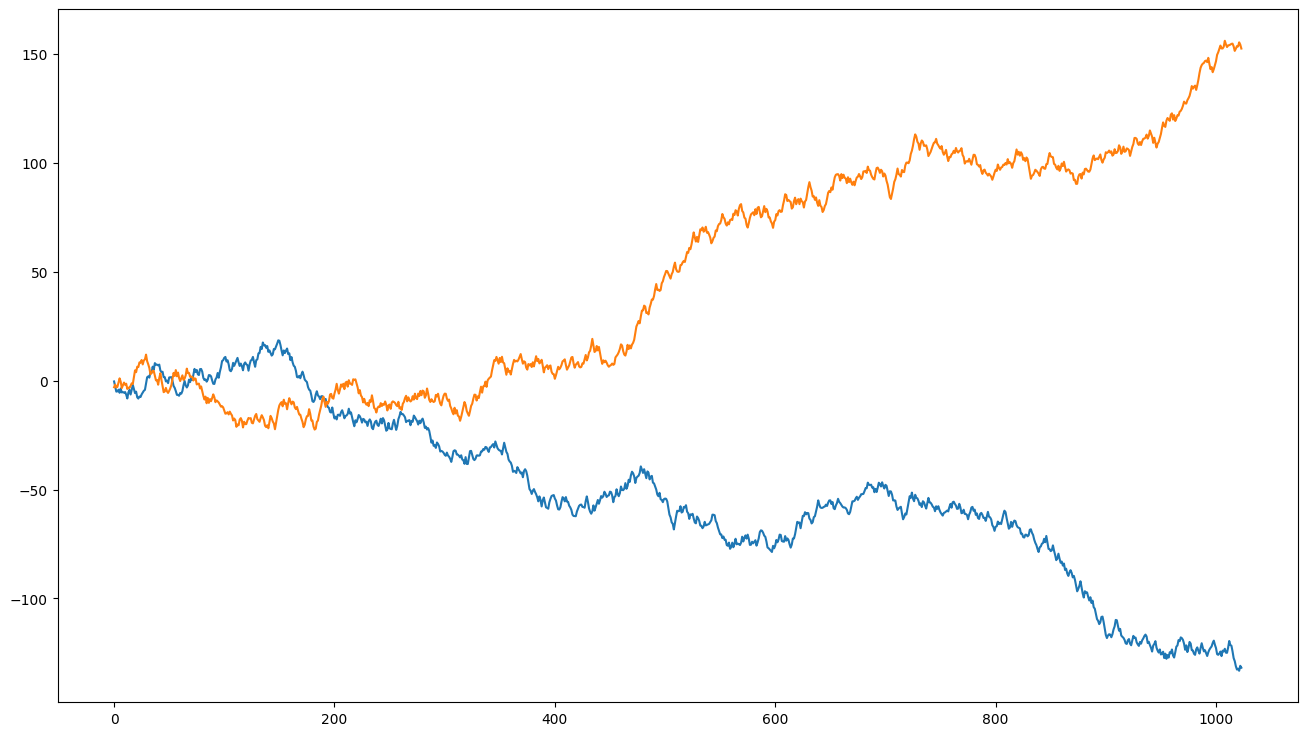

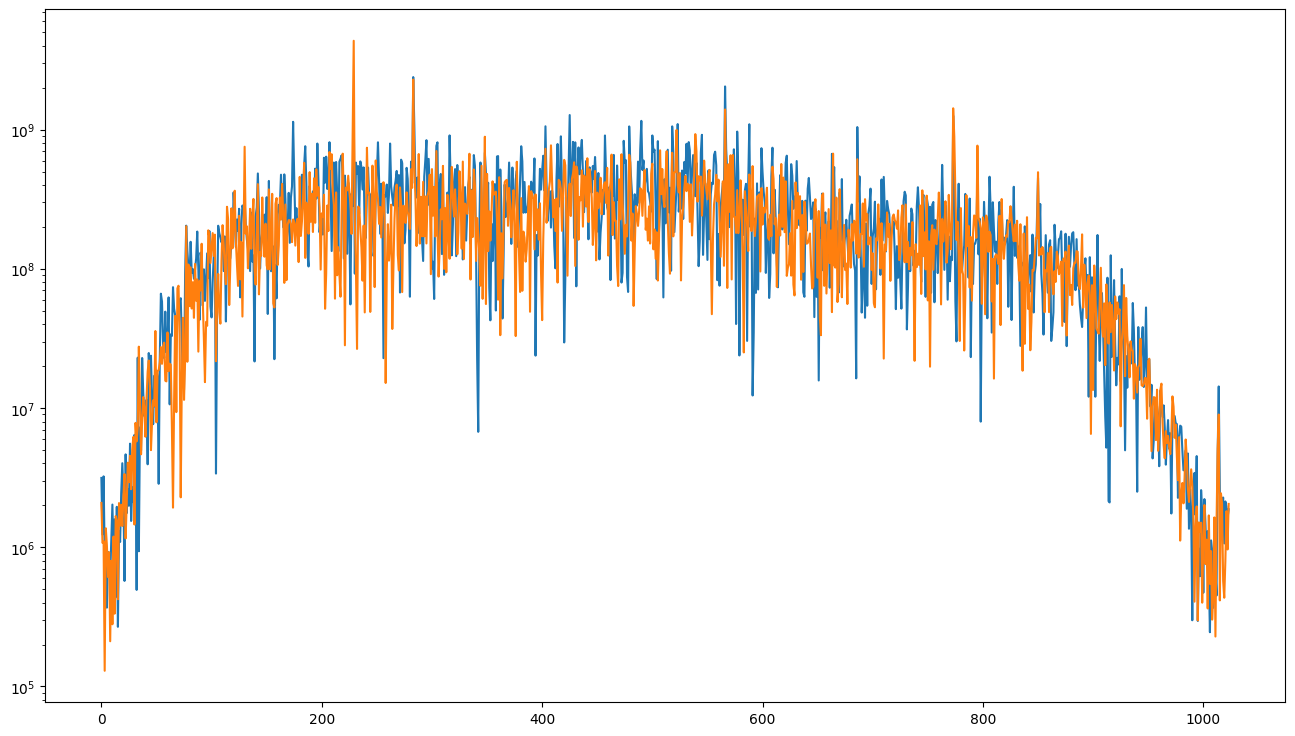

In [8]:
plt.figure(figsize=(16,9))
plt.plot(np.unwrap(np.angle(cross_spec_aligned)))
plt.plot(np.unwrap(np.angle(cross_spec_raw)))

plt.figure(figsize=(16,9))
plt.semilogy(np.abs(cross_spec_aligned))
plt.semilogy(np.abs(cross_spec_raw))


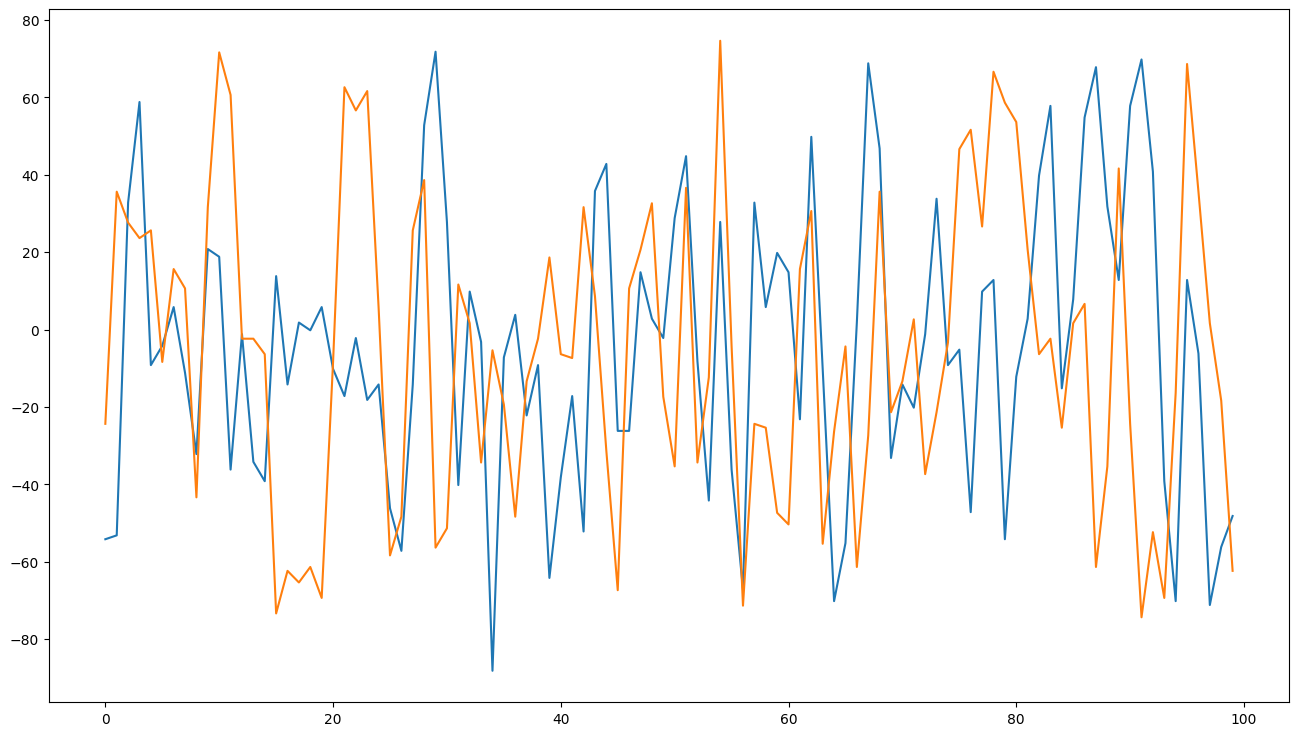

In [9]:
plt.figure(figsize=(16,9))
plt.plot(np.real(datum_1[0:100]))
plt.plot(np.imag(datum_2[0:100]))

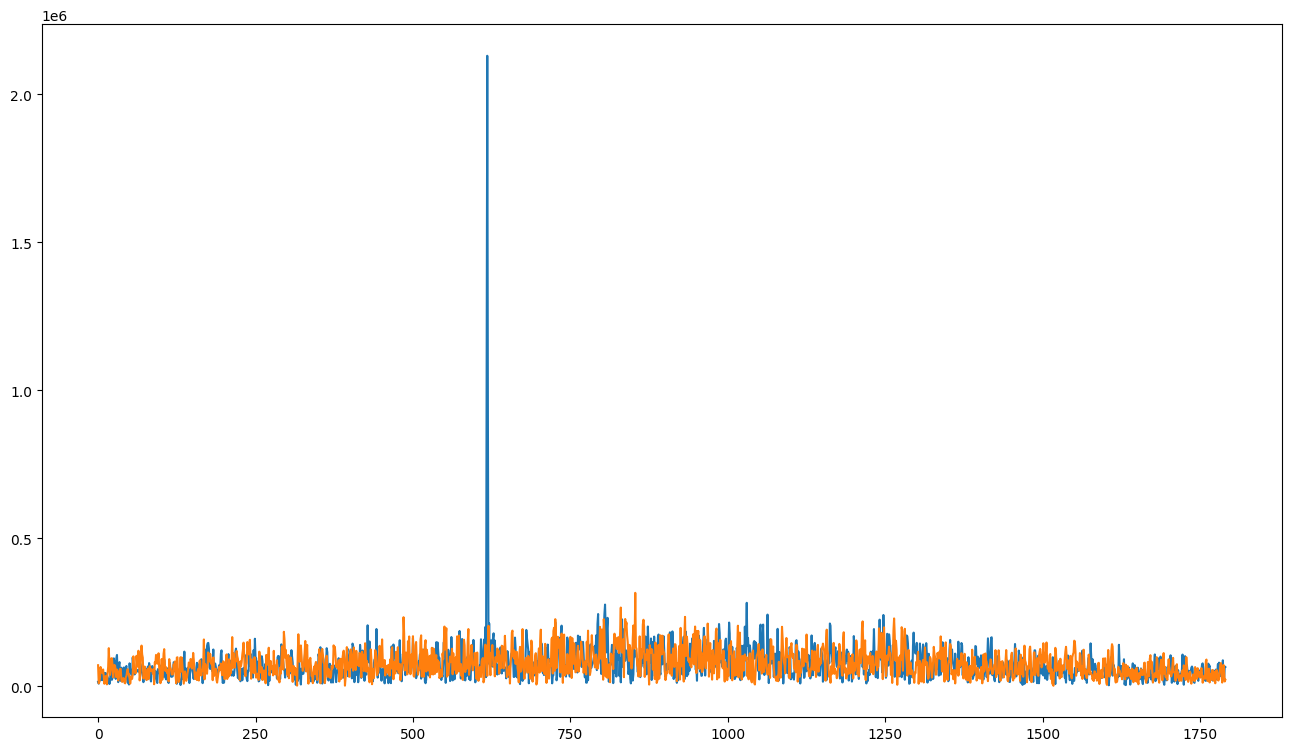

In [15]:
Ncorr = 1024

corrdat = np.correlate(datum_1[0:Ncorr], datum_2[0:Ncorr], mode='full')
corrraw = np.correlate(bindata_complex1[0:Ncorr], bindata_complex2[0:Ncorr], mode='full')
norm = np.correlate(np.ones(Ncorr), np.ones(Ncorr), mode='full')

plt.figure(figsize=(16,9))
plt.plot((np.abs(corrdat))[int(2*Ncorr/16):-int(2*Ncorr/16)])
plt.plot((np.abs(corrraw))[int(2*Ncorr/16):-int(2*Ncorr/16)])